# Alberi decisionali e interpretabilità dei modelli

In questo notebook introdurremo il concetto di alberi decisionali, una famiglia di modelli di machine learning molto utilizzati sia per task di classificazione che di previsione. Vediamo di cosa si tratta a livello concettuale, prima di passare a degli esempi pratici in Python.

#Introduzione
L'idea alla base dell'algoritmo è simile a un diagramma di flusso decisionale, dove si fanno delle domande con una risposta vero/falso e si imboccano strade diverse, andando a raggiungere una decisione finale dopo diversi passaggi. Nel nostro caso, l'albero decisionale può essere utilizzato per fare una classificazione binaria (come per la regressione logistica) o anche per predire un valore continuo (come per la regressione lineare).

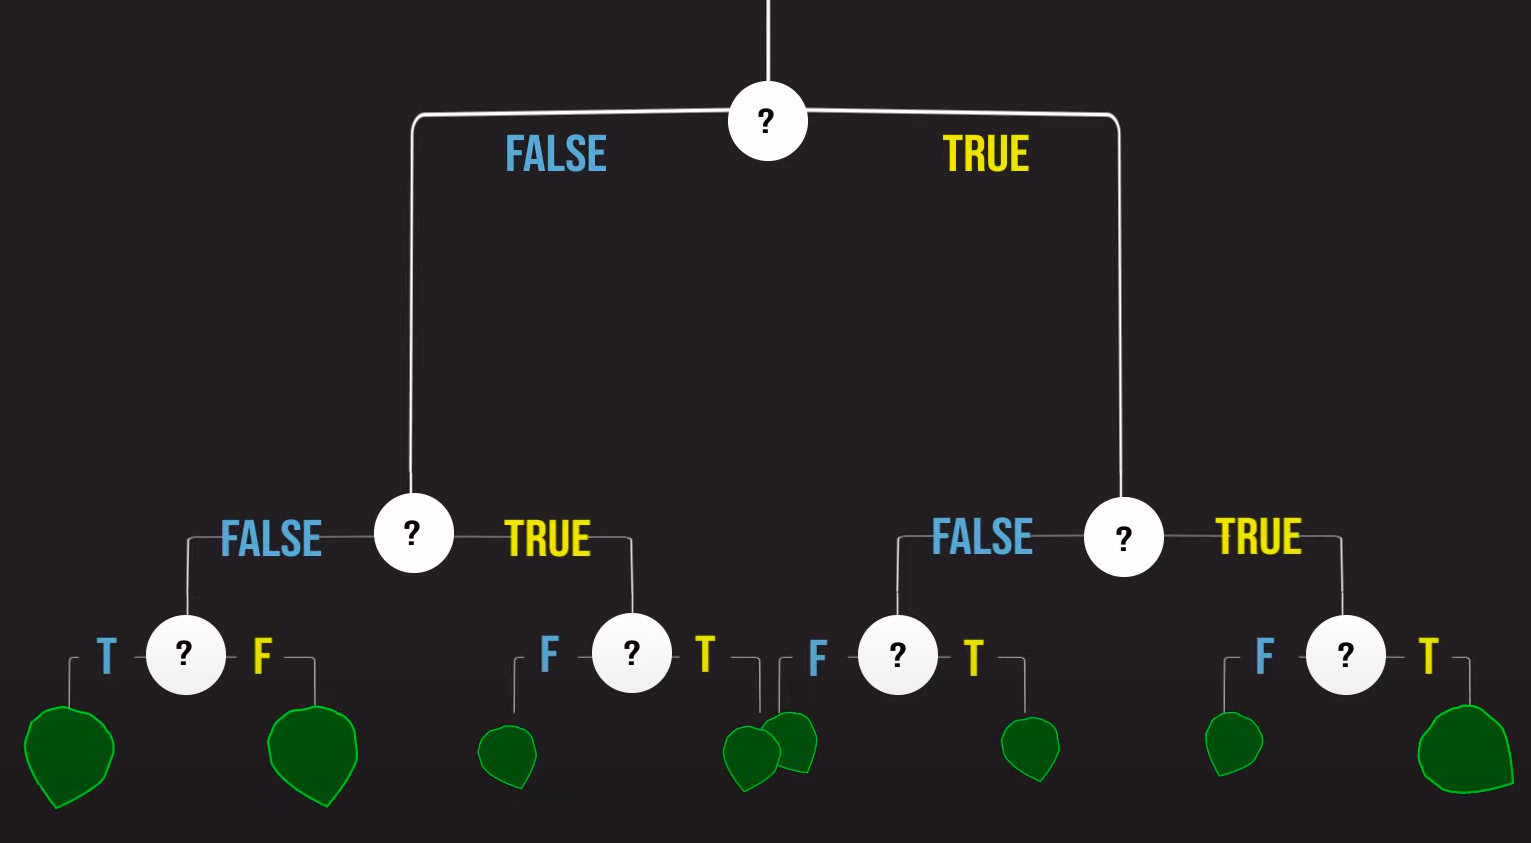

Per esempio, immaginiamo di avere un dataset di automobili con le seguenti caratteristiche: marca, modello, anno di produzione e prezzo. Possiamo creare un albero decisionale per prevedere se un'auto è costosa o economica in base alle sue caratteristiche. In questo caso, il primo nodo interno dell'albero decisionale potrebbe essere "L'auto è prodotta prima del 2010?". Se la risposta è sì, l'albero potrebbe continuare con la domanda "La marca dell'auto è tedesca?". Se la risposta è sì, l'albero potrebbe concludere che l'auto è costosa, altrimenti potrebbe concludere che l'auto è economica. Se la risposta alla prima domanda è no, l'albero potrebbe continuare con la domanda "Il modello dell'auto è sportivo?". Se la risposta è sì, l'albero potrebbe concludere che l'auto è costosa, altrimenti potrebbe concludere che l'auto è economica.

I punti di divergenza dove viene posta la domanda si chiamano *nodi* (node), di cui il primo è la *radice* dell'albero (root node). Ognuna delle due risposte ad ogni nodo da luogo a un *ramo* (branch) dell'albero decisionale, fino ad arrivare a una classificazione o predizione finale, detta *foglia* (leaf). Dato che solitamente abbiamo tante variabili, come possiamo scegliere quale utilizzare per creare i nodi? Questo viene stabilito internamente dall'algoritmo, che va a selezionare la variabile che produce la divisione più netta fra le due scelte possibili. Se per esempio abbiamo una variabile che è vera per il 90% dei dati, mentre le altre sono distribuite in modo più equo, questa diventerà il root node dell'albero decisionale. Questo aspetto è importante perché significa che abbiamo a disposizione l'informazione su quali siano le variabili più importanti nel classificare o predire i nostri dati, senza dover fare ulteriori analisi, semplicemente per come è costruito il modello. Questa informazione è molto utile quando vogliamo andare a spiegare i risultati del nostro modello, senza trattarlo come una black box. Torneremo su questo concetto più avanti.

# Overfitting e underfitting

Il processo di creazione di nuovi nodi e branch continua usando lo stesso criterio sulle variabili rimanenti per creare i nodi successivi, finché non si trovano solo sottoinsiemi "puri" (ossia con dati appartenenti solo a una categoria), oppure si raggiunge il numero massimo di branch impostati inizialmente (*profondità* dell'albero). Questo è un altro concetto importante, che si collega al problema più generale dell'*overfitting*. Soprattutto se i dati su cui stiamo costruendo il modello sono limitati o non sono completamente rappresentativi rispetto al problema trattato, è importante non utilizzare un modello eccessivamente complesso e dettagliato. Infatti questo potrebbe portare il modello a imparare dei trend e pattern presenti nei dati di training, che non rappresentano tendenze generali ma rumore statistico. In questo caso il modello farà delle classificazioni o predizioni errate su dati nuovi che non ha mai visto durante il training. Vediamo una rappresentazione del concetto di overfitting e underfitting:

In [ ]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

In [ ]:
#generiamo dati con forma sinusoidale con aggiunto un termine di dispersione casuale
np.random.seed(42)
npoints = 100
x = np.linspace(0, 7, npoints)
y = np.sin(x) + np.random.normal(scale=0.1, size=npoints)

#definiamo il grado delle funzioni polinomiali su cui provare dei fit
degrees = [1, 2, 3, 4, 5, 10, 20, 30, 50]

#creiamo il grafico
fig, axs = plt.subplots(3, 3, figsize=(15,15), sharey=True)
fig.suptitle('Overfitting and Underfitting')

#mostriamo i dati
for i, ax in enumerate(axs.flat):
    ax.scatter(x, y, s=10, c='b')
    ax.set_title('Degree = {}'.format(degrees[i]))
    ax.set_xlim([-0.5, 5.5])
    ax.set_ylim([-1.5, 1.5])
    ax.set_xlabel('x')
    ax.set_ylabel('y')

#creiamo il modello polinomiale e visualizziamo
xarr = np.linspace(0, 7, 1000)
for i, degree in enumerate(degrees):
    p = np.polyfit(x, y, degree)
    y_fit = np.polyval(p, xarr)
    axs.flat[i].plot(xarr, y_fit, c='r', lw=2)

plt.show()


Nel caso degli alberi decisionali è bene limitarne la complessità andando a impostare una *profondità* massima, ossia un numero massimo di nodi e branch, oltre i quali il modello non cercherà di dividere ulteriormente i dati e aumentare la sua complessità, e/o un numero minimo di osservazioni sotto il quale non viene creato un nuovo branch. In generale il problema dell'overfitting si può gestire andando a svolgere un'operazione di ottimizzazione dei parametri, o *parameter tuning*, che consiste nel testare diverse combinazioni dei parametri del modello andando a valutarne la performance su un dataset di test non visto in fase di training. Se si verifica overfitting, vedremo uno score molto migliore sui dati di training che su quelli di testing.

Vediamo delle spiegazioni visuali che illustrano questi concetti in modo intuitivo in queste pagine interattive:

http://www.r2d3.us/visual-intro-to-machine-learning-part-1/

http://www.r2d3.us/visual-intro-to-machine-learning-part-2/

# Esempio di modello albero decisionale
Vediamo un esempio utilizzando i nostri dati della Serie A, utilizzando un semplice albero decisionale per fare una classificazione binaria, tramite la funzione `DecisionTreeClassifier` di Scikit-learn, dove impostiamo una profondità massima di 6 branch. Un altro possibile modo di evitare overfitting è aumentare il numero minimo di dati per cui viene creato un nuovo nodo.

In [ ]:
from database.read_db import *

#leggiamo i dati e applichiamo il solito filtro sui minuti

df = read_db('ds.player_stats_clustering')

for c in df.select_dtypes(np.number).columns.to_list():
    if c not in ['player_id', 'team_id', 'mins_played', 'touches', 'full_name', 'team', 'soccRole']:
        df[f'{c}_p100'] = df[c] / df.touches * 100

In [ ]:
df.info()

In [ ]:
vars = [x for x in df.columns if x.endswith('_p100')]
X = df[vars]
y = (df.soccRole == 'FW')

tree_clf = DecisionTreeClassifier()
tree_clf.fit(X, y)

In [ ]:
y

Valutiamo la performance del modello tramite uno score semplice, la sua precisione (% di casi con predizione corretta)

In [ ]:
tree_clf.score(X,y)

E andiamo a vedere i risultati per un campione estratto a caso dai nostri dati tramite la funzione `sample` di Pandas.

In [ ]:
df['FW_predict'] = tree_clf.predict(X)
df['FW_prob'] = tree_clf.predict_proba(X)[:,1]

df.sort_values('np_shots_ibox_p100', ascending = False)[['full_name', 'soccRole', 'FW_predict', 'FW_prob']+vars].head(20)

# Spiegabilità dei modelli di machine learning
Abbiamo detto in precedenza che uno dei vantaggi degli alberi decisionali è che possiamo estrarre l'importanza delle variabili nel modello in modo semplice. Un modo veloce di accedere a questa informazione è tramite il parametro `feature_importances_` del nostro oggetto classificatore. I valori che vediamo rappresentano la diminuzione media in impurità del campione portata da uno split sulla variabile corrispondente, ossia quanto la variabile è capace di separare il dataset in insiemi distinti in base alla variabile target.

Andiamo a inserire questi valori, insieme ai nomi delle variabili, in un dataframe, e visualizziamo la loro importanza con un grafico a barre.

In [ ]:
df_fi = pd.DataFrame()
df_fi['stat'] = tree_clf.feature_names_in_
df_fi['importance'] = tree_clf.feature_importances_
df_fi.sort_values('importance', ascending = False, inplace = True)

In [ ]:
f, ax = plt.subplots(figsize=(7,5))
bars = ax.barh(y = df_fi.stat, width = df_fi.importance)
ax.bar_label(bars, fmt = '%.2f', padding = 5)
ax.invert_yaxis()
ax.set_xlabel('Feature importance')
plt.show()

Abbiamo anche a disposizione una funzione apposita di Scikit-learn (`plot_tree`) per visualizzare il nostro albero decisionale.

In [ ]:
plt.figure(figsize=(20,10))
plot_tree(tree_clf,
          feature_names=X.columns,
          filled = True,
          impurity = False,
          fontsize = 12)
plt.show()

L'intensità del colore di ogni nodo rappresenta la purezza, ossia l'uniformità del campione risultante in quel nodo, mentre il colore stesso rappresenta una maggioranza di casi positivi o negativi.

Possiamo anche usare altri strumenti per visualizzare questi concetti in modo ancora migliore. Uno dei più utili è dato dai cosiddetti *SHAP values* (abbreviazione di Shapley values). Si tratta di una tecnica di spiegazione dei modelli di machine learning che utilizza la teoria dei giochi per fornire una spiegazione del contributo di ciascuna variabile alla previsione del modello.

In un gioco cooperativo, i giocatori lavorano insieme per raggiungere un obiettivo comune, ma devono decidere come dividere la ricompensa finale. I valori Shapley sono una tecnica per determinare come dividere la ricompensa finale in modo equo tra i giocatori in base al loro contributo al successo del gioco.

Possiamo adattare quindi questa idea alla spiegazione dei modelli di machine learning. Invece di considerare i giocatori in un gioco cooperativo, consideriamo le variabili che influenzano la previsione del modello. Ciascuna variabile viene considerata come un "giocatore" e viene assegnato un valore SHAP che rappresenta il suo contributo alla previsione del modello.

Il valore SHAP di una variabile è calcolato considerando tutte le possibili combinazioni di variabili e determinando quanto ciascuna variabile contribuisce alla differenza tra la previsione con e senza quella variabile. In altre parole, il valore SHAP misura quanto la presenza di una variabile influisce sulla previsione complessiva del modello, rispetto alle altre variabili.

Vediamo come calcolare i valori SHAP e visualizzarli con l'apposita libreria Python.

In [ ]:
try:
  import shap
except:
  !pip install shap
  import shap

In [ ]:
explainer = shap.TreeExplainer(tree_clf)
shap_values = explainer.shap_values(X)[1]

Possiamo visualizzare una versione più informativa della feature importance tramite `summary_plot`, che ci mostrerà i valori SHAP di ogni punto del nostro dataset.

In [ ]:
shap.summary_plot(shap_values, X)

Vediamo che il numero di tiri da dentro l'area ha l'impatto maggiore, e in particolare valori alti (rosso) aumentano la probabilità che il giocatore sia un attaccante

Possiamo visualizzare più in dettaglio la dipendenza fra una feature e la variabile target tramite `dependence_plot`:

In [ ]:
shap.dependence_plot('np_shots_ibox_p100', shap_values, X)

Infine, una delle capacità più interessanti di questo strumento è quella di andarci a spiegare perché il modello ha resituito una certa predizione o probabilità per un particolare valore, tramite la funzione `force_plot`. La funzione richiede come primo input il valore atteso di una delle due classi. Se vogliamo selezionare la classe positiva, ossia il caso in cui il giocatore è un attaccante, prenderemo il secondo valore dell'oggetto `expected_value` dentro l'oggetto `explainer`. Questo valore non è altro che la media della nostra variabile target, ossia la % di giocatori che sono attaccanti, che come abbiamo visto rappresenta la base di partenza in quanto stima "ingenua" della probabilità di classificazione. Inseriamo poi i valori SHAP di una riga a caso, e indichiamo i nomi delle features. Il grafico risultante ci mostra chiaramente come il modello è arrivato alla sua predizione, e quali variabili hanno aumentato o ridotto il valore della predizione rispetto a quello di partenza.

In [ ]:
shap.force_plot(explainer.expected_value[1],
                shap_values[10],
                feature_names = vars,
                matplotlib = True)

In [ ]:
df.iloc[10]

La libreria SHAP è disponibile per diversi tipi di algoritmo, non solo per gli alberi decisionali, ed è uno strumento molto utile per non trattare i nostri modelli come scatole nere prendendo i risultati per buoni in modo acritico. Se per esempio abbiamo dei motivi per aspettarci una certa dipendenza per una feature, e il dependence plot ci mostra qualcosa di completamente diverso, e poco plausibile in base alle nostre conoscenze di dominio, probabilmente il modello andrà rivisto.

# Ensemble learning: bagging e boosting

Nella pratica, alberi decisionali semplici come quello che abbiamo appena visto non sono usati in modo diffuso. Gli algoritmi più efficaci e popolari in questo ambito sono algoritmi di *ensemble*, ossia modelli dati dalla combinazione di più alberi decisionali. In particolare ci sono due tipi di approccio molto utilizzati, *bagging* e *boosting*. Andiamo adesso a introdurre questi concetti, senza entrare troppo in dettaglio.

L'esempio principale di **bagging** con alberi decisionali è l'algoritmo *Random forest*. In questo approccio, vengono creati diversi alberi decisionali modellati su un diverso sottoinsieme dei dati, e usando un diverso sottoinsieme di variabili predittive. La predizione verrà quindi data dalla media delle predizioni dei singoli alberi (nel caso di variabile target continua), o dalla classe con più voti (nel caso di una classificazione).

Il vantaggio sta nel fatto che i diversi modelli saranno in grado di recuperare diversi pattern nei dati, sviluppando feature importance diverse, e andando a completarsi a vicenda. Se i modelli sono sufficientemente distinti, e ognuno ha una precisione di almeno il 50% (ossia fa meglio di una predizione completamente casuale), combinare le loro predizioni porterà il modello finale ad avere una precisione superiore. In altre parole, l'insieme di tanti modelli "deboli" (*weak learners*) da luogo ad un modello migliore. Infine, il fatto di creare i diversi modelli su sottoinsiemi diversi dei dati aiuta a prevenire l'overfitting.

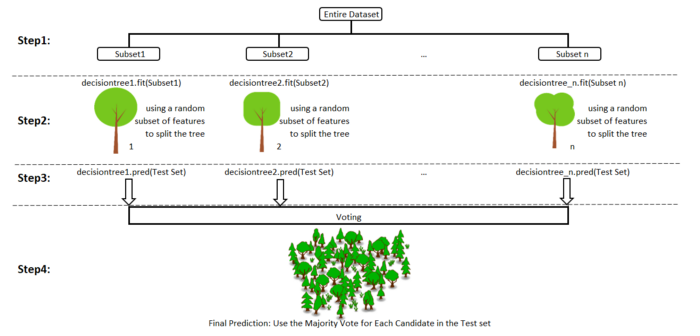

All'interno di Scikit-learn abbiamo a disposizione questo algoritmo tramite l'oggetto `RandomForestClassifier` per task di classificazione (variabile target categorica) e `RandomForestRegressor` per task di regressione (variabile target numerica). Uno dei grandi vantaggi di Scikit-learn è che quasi tutti i modelli funzionano con lo stesso metodo dal punto di vista del codice, ossia hanno le stesse funzioni interne principali come `fit`, `predict` e `predict_proba`, per cui si usa nello stesso modo che abbiamo già visto diverse volte durante il corso. Anche i discorsi fatti sugli SHAP values sono validi anche per questi modelli.

Gli algoritmi di **boosting** si basano anch'essi sulla combinazione di alberi decisionali, ma invece di combinare modelli in modo orizzontale come visto nel bagging, li combinano in modo verticale: ogni albero cerca di correggere gli errori fatti da quello precedente, in una sequenza di modelli dove ognuno prende in input i residui del modello precedente. Un sottoinsieme di questo tipo di algoritmo è formata dai modelli di **gradient boosting**, di cui un'implementazione molto popolare è XGboost (Extreme Gradient Boosting). Anche in questo caso è possibile ottenere prestazioni significativamente migliori rispetto ad un albero decisionale semplice. D'altro canto, la concessione che si fa è di aumentare la complessità del modello, che comporta molti più parametri rispetto ad un albero decisionale semplice, che andranno quindi studiati e ottimizzati per il nostro caso specifico. Scikit-learn contiene una funzione di gradient boosting, mentre XGboost ha una libreria Python a parte.